# The Future is Now: Patterns in Global Temperature Trends Across the World

While we all know that global temperatures are on the rise, mass media tends to lack nuance on the topic with its goals of compressing information into brief soundbytes.

For example, it's often not mentioned that the global temperature rise is based on *average* global temperatures, rather than day-to-day, which often leads people to conflate climate and weather. It is also worth highlighting that averages can be skewed by outliers - i.e., unusually hot or cold temperatures on just a few days out of a month can make the average temperature for that month higher or lower by several degrees.

Another feature of climate change not often highlighted is that different parts of the world are warming at different rates,  i.e. some parts of the world are more at risk for the various consequences of climate change than others, particularly in the short term (decades). 

The goal of this analysis is to find which parts of the world have warmed the most. What geographic trends will we find? What regions of the world are most at risk? With data mining techniques, we can better understand which parts of the world will be most at risk, and help provide a more nuanced understanding of climate change.

The following analysis is based on this dataset: [Global Temperature Records (1743-2013)](https://www.kaggle.com/datasets/maso0dahmed/global-temperature-records-1850-2022).

## Virtual Environment Setup

Recommended if running locally; not needed if running on Colab or similar.

In [1]:
!py -3 -m venv .venv

## Install Dependencies

In [1]:
#!python -m pip install pandas numpy scikit-learn matplotlib missingno pyarrow  pycountry_convert kgcpy
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow  pycountry_convert kgcpy

  Using cached pandas-2.2.1-cp310-cp310-win_amd64.whl (11.6 MB)
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
  Using cached scikit_learn-1.4.1.post1-cp310-cp310-win_amd64.whl (10.6 MB)
  Using cached matplotlib-3.8.3-cp310-cp310-win_amd64.whl (7.6 MB)
  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
  Using cached pyarrow-15.0.2-cp310-cp310-win_amd64.whl (24.8 MB)
  Using cached pycountry_convert-0.7.2-py3-none-any.whl (13 kB)
  Using cached kgcPy-1.1.3-py3-none-any.whl (833 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl (17 kB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached scipy-1.12.0-cp310-cp310-win_amd64.whl (46.2 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.50.0-cp310-cp310-win_amd64.whl (2.2 MB)
  Using cached pillow-10.2.0-cp310-cp310-win_amd64.whl (2.6 MB)
  Using c

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pycountry_convert as pc
from kgcPy import lookupCZ

## Data preprocessing & Exploratory Data Analysis (EDA)

For our first step, I need to examine the data, and determine if there are any data missing; if there are, I should investigate patterns in the missing data.

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64


<Axes: >

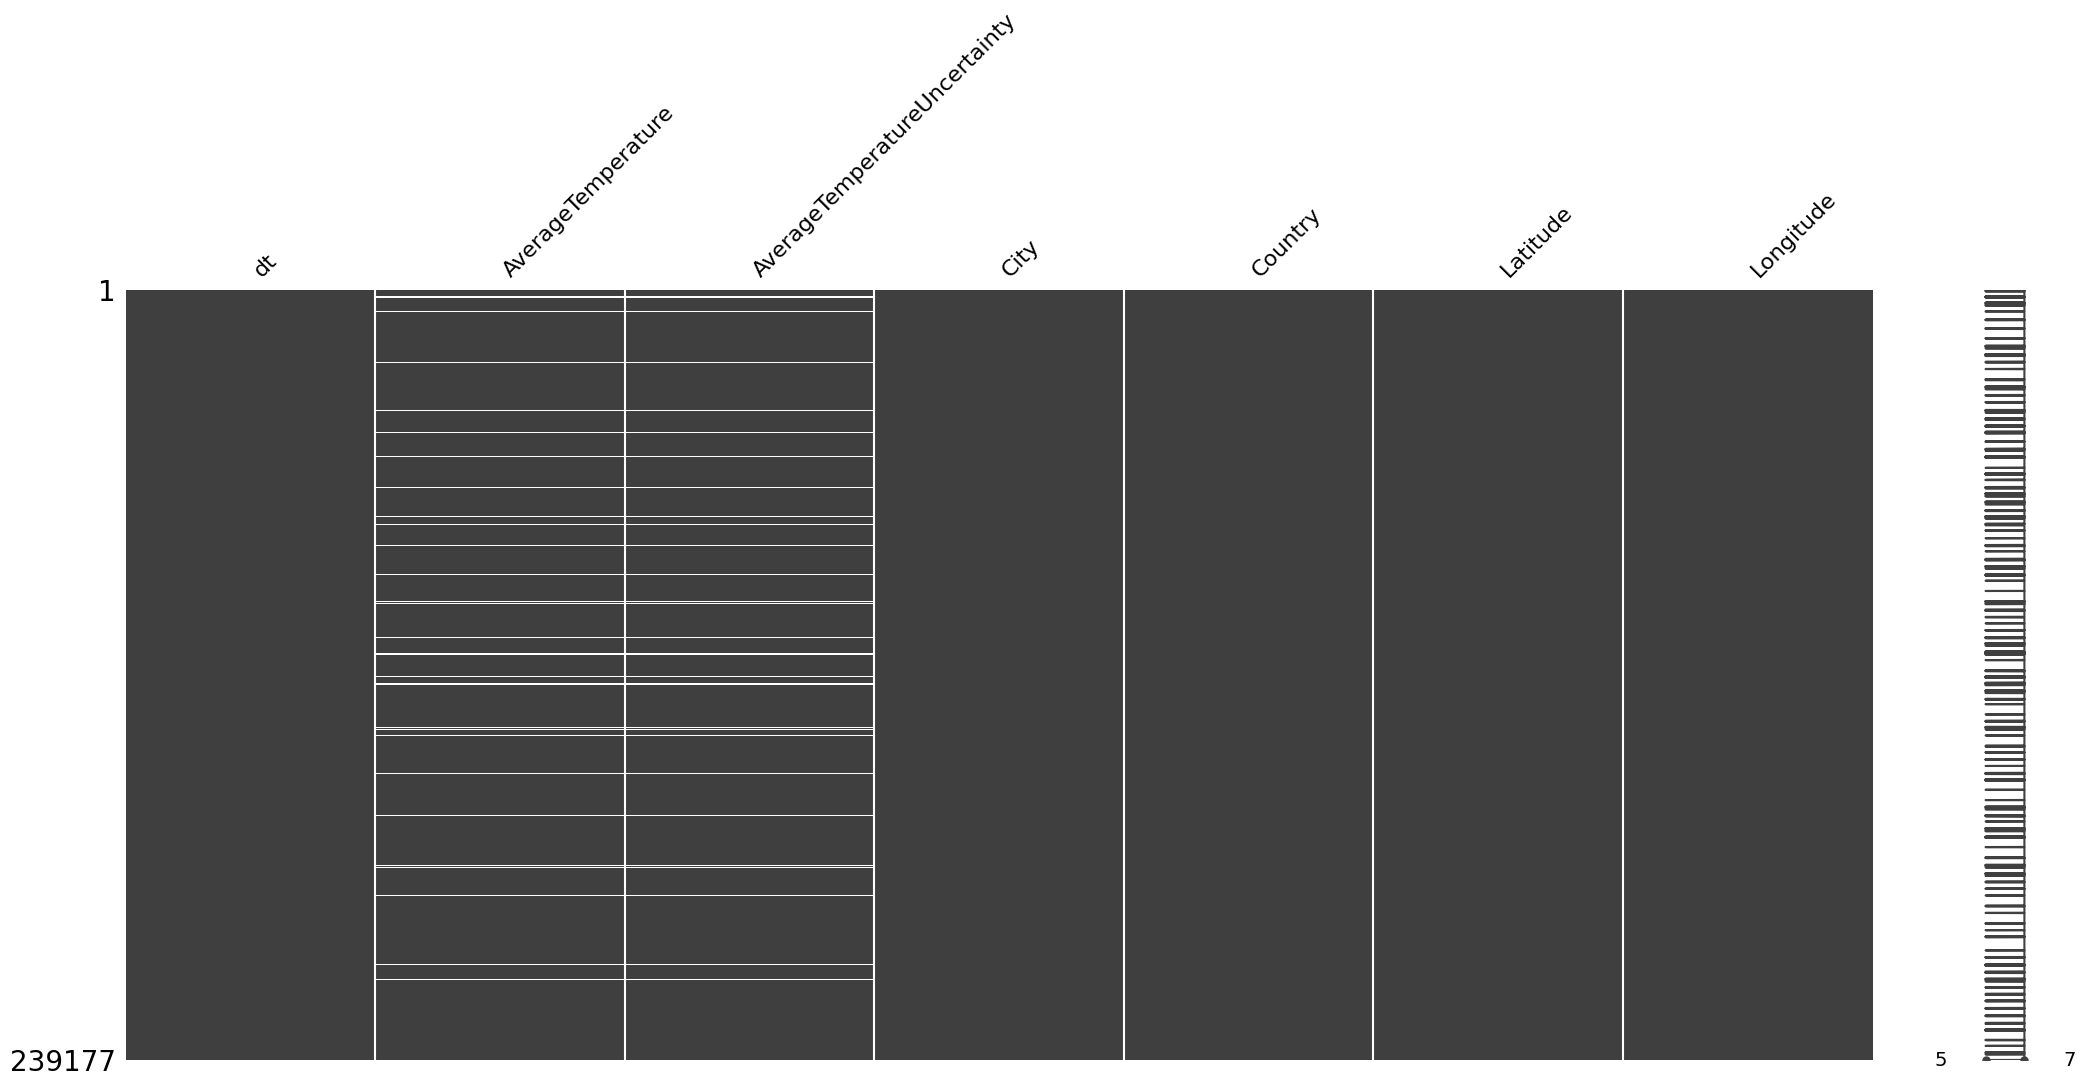

In [4]:
with open('GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv', 'r') as file:
    df = pd.read_csv(file)

# Find missing values (if any) and where they are
missing = df.isnull().sum()
print(missing)

msno.matrix(df)

Quick look at how the data is organized

In [9]:
unique_cities_count = df['City'].nunique()
print(f"Number of unique cities: {unique_cities_count}")

unique_cities_count = df['Country'].nunique()
print(f"Number of unique countries: {unique_cities_count}")

df.describe()

Number of unique cities: 100
Number of unique countries: 49


,AverageTemperature,AverageTemperatureUncertainty
count,228175.000000,228175.000000
mean,18.125969,0.969343
std,10.024800,0.979644
min,-26.772000,0.040000
25%,12.710000,0.340000
50%,20.428000,0.592000
75%,25.918000,1.320000
max,38.283000,14.037000


### Missing Data

From the output above we can see that there are a lot of missing data points, but all of them are in the AverageTemperature column and its dependent column, AverageTemperatureUncertainty. Next I will try to find patterns in the missing values (certain countries or years) to decide on how to approach them.

In [18]:
# Convert 'dt' to datetime and extract the year
df['Year'] = pd.to_datetime(df['dt']).dt.year

# Group by city/year to find where most of the values are missing
df_missing_city_year = df[df['AverageTemperature'].isnull()].groupby(['City', 'Year']).size().reset_index(name='MissingCount')
print('Missing Average Temperature entries by year and city:')
print(df_missing_city_year)

# Look at just city to see geographical trends
df_missing_city = df[df['AverageTemperature'].isnull()].groupby('City').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by city:')
print(df_missing_city)

# Look at just year to see temporal trends
df_missing_years_city = df[df['AverageTemperature'].isnull()].groupby('Year').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by year (across all cities):')
print(df_missing_years_city)

Missing Average Temperature entries by year and city:
         City  Year  MissingCount
0     Abidjan  1852            12
1     Abidjan  1853            12
2     Abidjan  1854            12
3     Abidjan  1855            12
4     Abidjan  1856             6
...       ...   ...           ...
1391     Xian  1837             9
1392     Xian  1838            12
1393     Xian  1839            12
1394     Xian  1867             1
1395     Xian  2013             1

[1396 rows x 3 columns]

Missing Average Temperature entries by city:
             City  MissingCount
41        Jakarta           386
85       Surabaya           386
25  Dar Es Salaam           379
30      Fortaleza           366
47        Karachi           289
..            ...           ...
43          Jinan             1
39          Izmir             1
34         Harbin             1
32      Guangzhou             1
96          Wuhan             1

[98 rows x 2 columns]
Missing Average Temperature entries by year (across all citi

Visualization of Missing Data

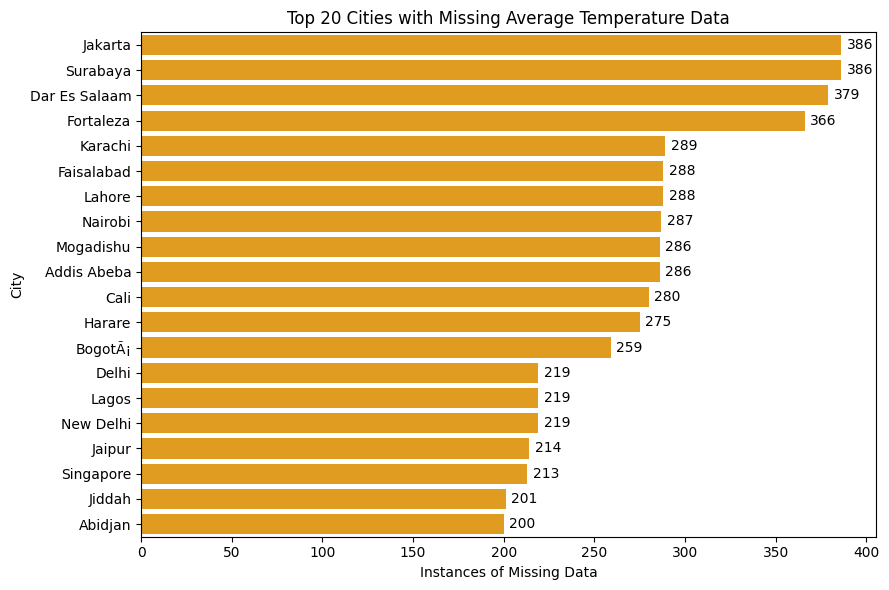

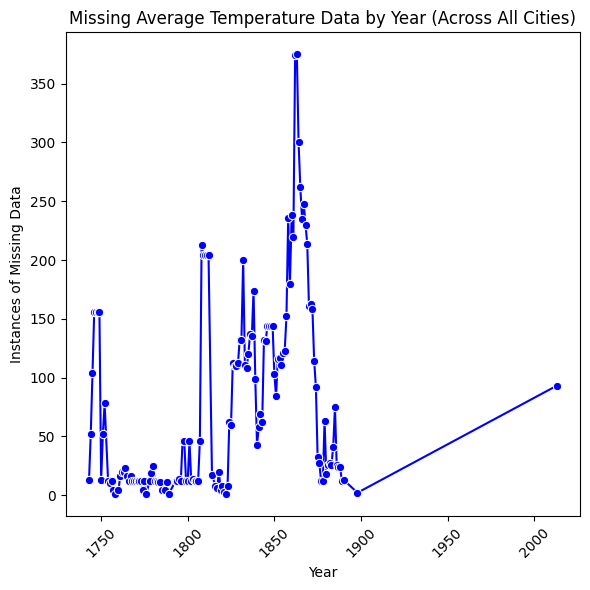

In [19]:
plt.figure(figsize=(9, 6))
plot = sns.barplot(x='MissingCount', y='City', data=df_missing_city.head(20), color='orange')
plt.title('Top 20 Cities with Missing Average Temperature Data')
plt.xlabel('Instances of Missing Data')
plt.ylabel('City')

# Adjusting text placement for readability
for bar in plot.patches:
    width = bar.get_width()
    plot.text(width + 3, bar.get_y() + bar.get_height() / 2, '{:1.0f}'.format(width), va='center')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
sns.lineplot(x='Year', y='MissingCount', data=df_missing_years_city, marker='o', color='b')
plt.title('Missing Average Temperature Data by Year (Across All Cities)')
plt.xlabel('Year')
plt.ylabel('Instances of Missing Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Handling Years With Missing Data

Inevitably, some years will have a month or perhaps a whole year's Average Temperature data missing.

Including years with some months missing could easily misrepresent the average, particularly for countries far from the equator, where there can be a large seasonal variation in temperature. We want to minimize the influence of incomplete or missing data.

To keep the reliability and integrity of this data analysis, I will be using the following approach:

1. Exclude all years for a city where at least 1 month is missing a value for AverageTemperature, put that in a new dataframe.
2. Average the temperature for each year on the rest of the data, so we can compare temperature trends over time across countries.

In [21]:
# Step 1: 

# Find any cities that have missing temperature data for a year
missing_AverageTemperature = df.groupby(['City', 'Year'])['AverageTemperature'].apply(lambda x: x.isnull().any()).reset_index(name='HasMissing')

# Create a new df that only includes years without missing data
df_no_missing = missing_AverageTemperature[~missing_AverageTemperature['HasMissing']]

# Filter to only include rows with complete years - now we've only got years with 0 missing Average Temperature entries
df_no_missing = pd.merge(df, df_no_missing[['City', 'Year']], on=['City', 'Year'], how='inner')

# Step 2:

# Calculate the average temperature for each city by year
df_AverageTemperature_City_Year = df_no_missing.groupby(['City', 'Year'])['AverageTemperature'].mean().reset_index()

print(df_AverageTemperature_City_Year)

df_AverageTemperature_City_Year.describe()

          City  Year  AverageTemperature
0      Abidjan  1849           25.582583
1      Abidjan  1850           25.518250
2      Abidjan  1851           25.672333
3      Abidjan  1858           25.486750
4      Abidjan  1859           25.920917
...        ...   ...                 ...
18575     Xian  2008           12.128750
18576     Xian  2009           12.528417
18577     Xian  2010           12.589750
18578     Xian  2011           12.075167
18579     Xian  2012           11.898167

[18580 rows x 3 columns]


,Year,AverageTemperature
count,18580.000000,18580.000000
mean,1915.469968,18.089322
std,60.715929,7.515542
min,1753.000000,1.317000
25%,1872.000000,11.450479
50%,1920.000000,19.211333
75%,1966.000000,25.348917
max,2013.000000,30.730167


We want to exclude years with too few data points. As shown below, the most data points we have for any city is 49. We will only keep those with about 2/3 of that number (32) both for accuracy and to keep as many data points as reasonable for later analysis.

In [25]:
unique_cities_count = df_AverageTemperature_City_Year['City'].nunique()
print(f'Number of unique cities: {unique_cities_count}')

# Group by Year and count the number of data points (countries) for each year
num_data_points = df_AverageTemperature_City_Year.groupby('Year').size()

# Print minimum and maximum number of data points across all years
print(f'Minimum data points in a year: {num_data_points.min()}')
print(f'Maximum data points in a year: {num_data_points.max()}')

# Find years with fewer than 1/5 * max data points
threshold = (1/3) * num_data_points.max()
years_with_lt_one_third = num_data_points[num_data_points < threshold]

print(f'Number of years with fewer than {int(threshold)} data points: {len(years_with_lt_one_third)}')
print(years_with_lt_one_third)

years_to_exclude = years_with_lt_one_third.index.tolist()
df_AverageTemperature_City_Year = df_AverageTemperature_City_Year[~df_AverageTemperature_City_Year['Year'].isin(years_to_exclude)]

Number of unique cities: 100
Minimum data points in a year: 34
Maximum data points in a year: 100
Number of years with fewer than 33 data points: 0
Series([], dtype: int64)


The most data points we have for a year is 100/100, and the least is 7/100. We have filtered our dataframe to only include those with at least 44 unique cities.

### View of Average Temperature Over Time for 5 Random Countries

To verify that my approach is giving the correct results, I have decided to graph 5 random countries' average temperature over time.
Your results will be different every time you run the following cell.

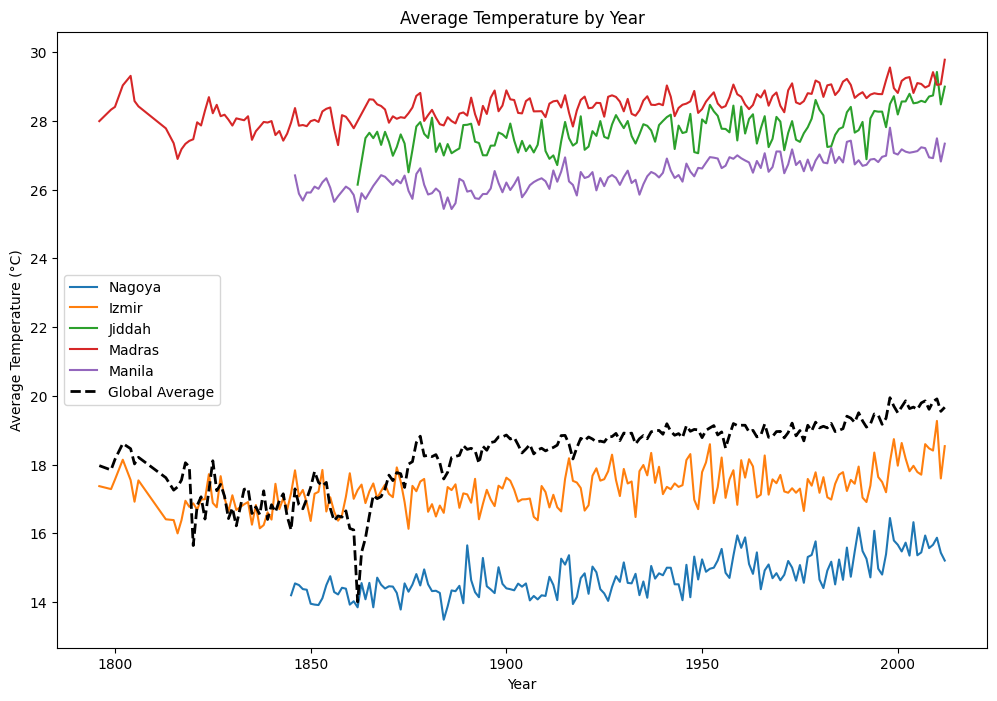

In [51]:
# Get list of unique countries so we can graph by country
unique_cities = df_AverageTemperature_City_Year['City'].unique()

# Pick 5 random countries
selected_cities = np.random.choice(unique_cities, 5, replace=False)

plt.figure(figsize=(12, 8))

# Graph AverageTemperature vs. Year for the 5 random countries
for city in selected_cities:
    city_data = df_AverageTemperature_City_Year[df_AverageTemperature_City_Year['City'] == city]
    plt.plot(city_data['Year'], city_data['AverageTemperature'], label=city)

# Include global for comparison
df_global_average = df_AverageTemperature_City_Year.groupby('Year')['AverageTemperature'].mean().reset_index(name='GlobalAverageTemperature')
plt.plot(df_global_average['Year'], df_global_average['GlobalAverageTemperature'], label='Global Average', color='black', linewidth=2, linestyle='--')

plt.title('Average Temperature by Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

### Correlation Between Latitude and Average Temperature

Latitude is a value measured in degrees with range [-90, 90] that represents physical distance from the equator (0). Cities north of the equator have their latitude suffixed by N (positive), and those south of the equator have it suffixed by S (negative).

For this analysis it makes the most sense to look at absolute latitude to determine if there is a correlation between it and average temperature, since the output should be a line (if there is a correlation). However I will also be examining raw latitude as well, to see if there are any trends within just the Northern or Southern Hemisphere. We expect this curve to be a slightly skewed inverted-U shape since there is less landmass in the southern hemisphere.

It is expected that countries near the equator should have warmer average temperatures than those far from the equator.

In [52]:
additional_details = df_no_missing.groupby(['City', 'Year']).agg({
    'Country': 'first',
    'Latitude': 'first', 
    'Longitude': 'first'
}).reset_index()

# Merging back with df_AverageTemperature_City_Year
df_no_missing_updated = pd.merge(
    df_AverageTemperature_City_Year,
    additional_details,
    on=['City', 'Year'],
    how='left'
)

print(df_no_missing_updated)

          City  Year  AverageTemperature        Country Latitude Longitude
0      Abidjan  1849           25.582583  Cote D'Ivoire    5.63N     3.23W
1      Abidjan  1850           25.518250  Cote D'Ivoire    5.63N     3.23W
2      Abidjan  1851           25.672333  Cote D'Ivoire    5.63N     3.23W
3      Abidjan  1858           25.486750  Cote D'Ivoire    5.63N     3.23W
4      Abidjan  1859           25.920917  Cote D'Ivoire    5.63N     3.23W
...        ...   ...                 ...            ...      ...       ...
17726     Xian  2008           12.128750          China   34.56N   108.97E
17727     Xian  2009           12.528417          China   34.56N   108.97E
17728     Xian  2010           12.589750          China   34.56N   108.97E
17729     Xian  2011           12.075167          China   34.56N   108.97E
17730     Xian  2012           11.898167          China   34.56N   108.97E

[17731 rows x 6 columns]


In [53]:
# Add additional latitude/longitude columns for data visualization/processing
df_no_missing_updated['NumericLatitude'] = df_no_missing_updated['Latitude'].apply(lambda x: float(x[:-1]) if 'N' in x else -float(x[:-1]))
df_no_missing_updated['NumericLongitude'] = df_no_missing_updated['Longitude'].apply(lambda x: float(x[:-1]) if 'E' in x else -float(x[:-1]))
df_no_missing_updated['AbsLatitude'] = df_no_missing_updated['NumericLatitude'].abs()
df_no_missing_updated['AbsLongitude'] = df_no_missing_updated['NumericLongitude'].abs()

df_no_missing_updated = df_no_missing_updated.dropna(subset=['AverageTemperature'])

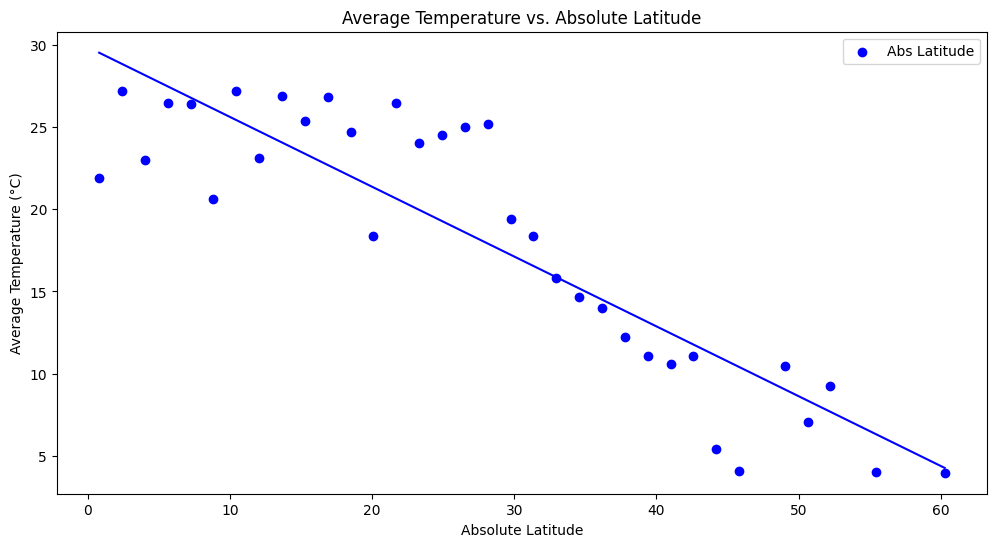

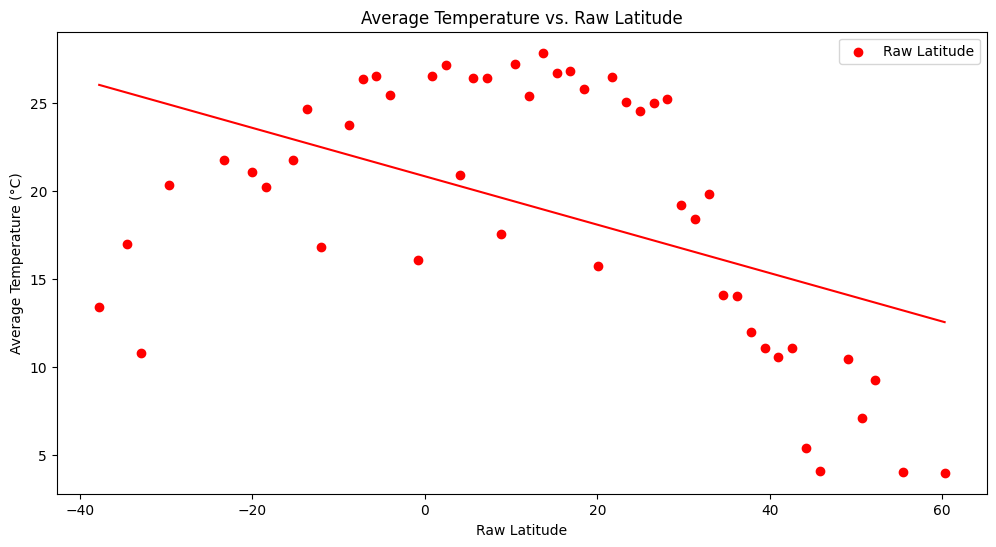

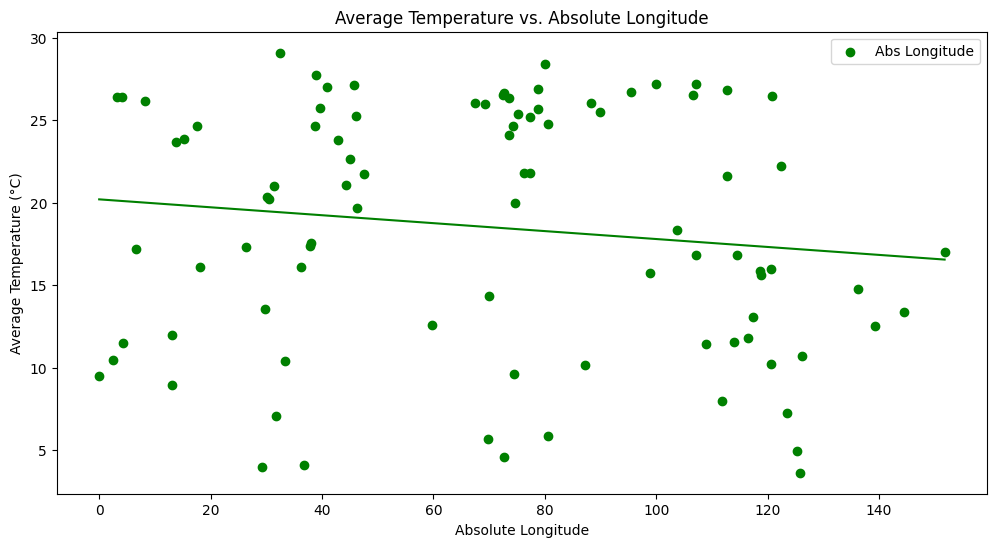

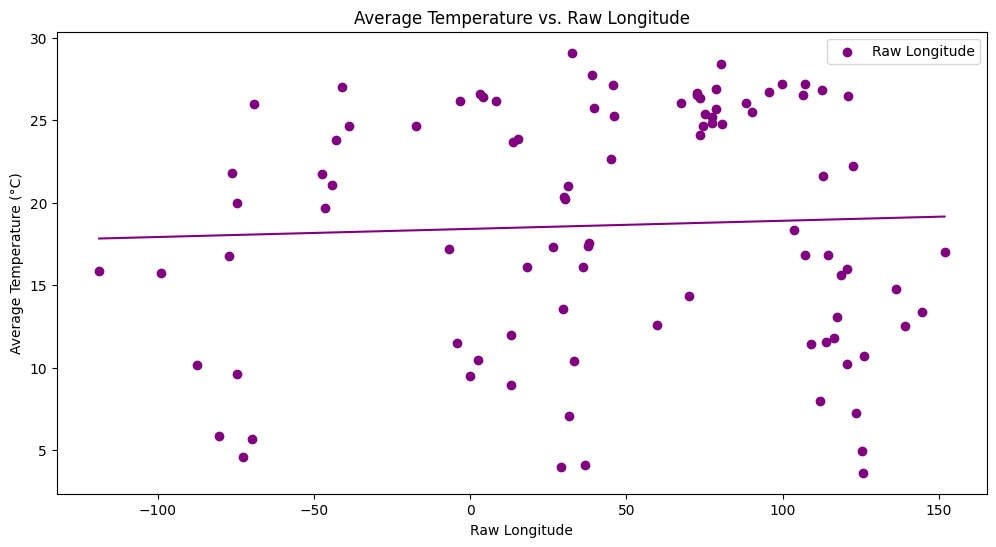

Correlation between Absolute Latitude and Average Temperature: -0.8881019375147553
Correlation between Raw Latitude and Average Temperature: -0.48605640027458147
Correlation between Absolute Longitude and Average Temperature: -0.8028814952953963
Correlation between Raw Longitude and Average Temperature: -0.33918072763884216


In [54]:
average_temp_by_latitude = df_no_missing_updated.groupby('AbsLatitude')['AverageTemperature'].mean().reset_index()
average_temp_by_raw_latitude = df_no_missing_updated.groupby('NumericLatitude')['AverageTemperature'].mean().reset_index()
average_temp_by_longitude = df_no_missing_updated.groupby('AbsLongitude')['AverageTemperature'].mean().reset_index()
average_temp_by_raw_longitude = df_no_missing_updated.groupby('NumericLongitude')['AverageTemperature'].mean().reset_index()

# Correlation Analysis
correlation_abs_lat = average_temp_by_latitude['AbsLatitude'].corr(average_temp_by_latitude['AverageTemperature'])
correlation_raw_lat = average_temp_by_raw_latitude['NumericLatitude'].corr(average_temp_by_raw_latitude['AverageTemperature'])
correlation_abs_long = average_temp_by_longitude['AbsLongitude'].corr(average_temp_by_latitude['AverageTemperature'])
correlation_raw_long = average_temp_by_raw_longitude['NumericLongitude'].corr(average_temp_by_raw_latitude['AverageTemperature'])

# Visualization for AbsLatitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_latitude['AbsLatitude'], average_temp_by_latitude['AverageTemperature'], color='blue', label='Abs Latitude')
m, b = np.polyfit(average_temp_by_latitude['AbsLatitude'], average_temp_by_latitude['AverageTemperature'], 1)
plt.plot(average_temp_by_latitude['AbsLatitude'], m*average_temp_by_latitude['AbsLatitude'] + b, color='blue')
plt.title('Average Temperature vs. Absolute Latitude')
plt.xlabel('Absolute Latitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for Raw Latitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_raw_latitude['NumericLatitude'], average_temp_by_raw_latitude['AverageTemperature'], color='red', label='Raw Latitude')
m, b = np.polyfit(average_temp_by_raw_latitude['NumericLatitude'], average_temp_by_raw_latitude['AverageTemperature'], 1)
plt.plot(average_temp_by_raw_latitude['NumericLatitude'], m*average_temp_by_raw_latitude['NumericLatitude'] + b, color='red')
plt.title('Average Temperature vs. Raw Latitude')
plt.xlabel('Raw Latitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for AbsLongitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_longitude['AbsLongitude'], average_temp_by_longitude['AverageTemperature'], color='green', label='Abs Longitude')
m, b = np.polyfit(average_temp_by_longitude['AbsLongitude'], average_temp_by_longitude['AverageTemperature'], 1)
plt.plot(average_temp_by_longitude['AbsLongitude'], m*average_temp_by_longitude['AbsLongitude'] + b, color='green')
plt.title('Average Temperature vs. Absolute Longitude')
plt.xlabel('Absolute Longitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for Raw Longitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_raw_longitude['NumericLongitude'], average_temp_by_raw_longitude['AverageTemperature'], color='purple', label='Raw Longitude')
m, b = np.polyfit(average_temp_by_raw_longitude['NumericLongitude'], average_temp_by_raw_longitude['AverageTemperature'], 1)
plt.plot(average_temp_by_raw_longitude['NumericLongitude'], m*average_temp_by_raw_longitude['NumericLongitude'] + b, color='purple')
plt.title('Average Temperature vs. Raw Longitude')
plt.xlabel('Raw Longitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

print(f"Correlation between Absolute Latitude and Average Temperature: {correlation_abs_lat}")
print(f"Correlation between Raw Latitude and Average Temperature: {correlation_raw_lat}")
print(f"Correlation between Absolute Longitude and Average Temperature: {correlation_abs_long}")
print(f"Correlation between Raw Longitude and Average Temperature: {correlation_raw_long}")

For all but Absolute Latitude and Average Temperature, the lines are poor fits for the data. This makes sense since Latitude is a direct predictor of climate due to the angle at which solar radiation is received, while Longitude has no such effects.

The high correlation with Absolute Longitude and Average Temperature would seem viable had we not included the visualization, but clearly the data distribution is not linear. The large number of outliers greatly affects the slope of the regression line. This doesn't meant here is no relationship, however. There may be another relationship here that we can tease out.

### Results of Correlation Between Latitude and Average Temperature

The results are about as expected; a strong negative correlation between absolute latitude an negative temperature (r^2 ~= -0.89), and a nearly even correlation when raw latitude is used (expected r^2 ~= 0.50, actual ~= -0.49).

Perfect correlations are not to be expected, since many more factors affect local climates than distance from the equator, such as weather patterns and topography.

### Enhancing the Dataset

Adding a continent column to our dataset could potentially be useful to find macro-scale trends.

In [55]:
# Function to get continent name from country name
def country_to_continent(country_name):
    # Special cases (different country names than pycountry_convert uses)
    special_cases = {
        "Cote D'Ivoire": "Africa",
        "Congo (Democratic Republic Of The)": "Africa",
        "Burma": "Asia", 
    }
    
    if country_name in special_cases:
        return special_cases[country_name]
    
    try:
        # Get country code and continent code
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

df_no_missing_updated['Continent'] = df_no_missing_updated['Country'].apply(country_to_continent)

print(df_no_missing_updated)

# Verify that all countries were assigned a continent
none_continent_rows = df_no_missing_updated.loc[df_no_missing_updated['Continent'].isnull()]
print(none_continent_rows)


          City  Year  AverageTemperature        Country Latitude Longitude  \
0      Abidjan  1849           25.582583  Cote D'Ivoire    5.63N     3.23W   
1      Abidjan  1850           25.518250  Cote D'Ivoire    5.63N     3.23W   
2      Abidjan  1851           25.672333  Cote D'Ivoire    5.63N     3.23W   
3      Abidjan  1858           25.486750  Cote D'Ivoire    5.63N     3.23W   
4      Abidjan  1859           25.920917  Cote D'Ivoire    5.63N     3.23W   
...        ...   ...                 ...            ...      ...       ...   
17726     Xian  2008           12.128750          China   34.56N   108.97E   
17727     Xian  2009           12.528417          China   34.56N   108.97E   
17728     Xian  2010           12.589750          China   34.56N   108.97E   
17729     Xian  2011           12.075167          China   34.56N   108.97E   
17730     Xian  2012           11.898167          China   34.56N   108.97E   

       NumericLatitude  NumericLongitude  AbsLatitude  AbsLongi

### Enhancing the Dataset

The Köppen climate classification divides every region of the world into five main groups, each represented by a letter, and thirty subgroups with additional letters. We may be able to find tighter correlations between temperature trends if we also take into account the climate classification of each city in this dataset.

I will add a column with the Köppen climate classification for each city with data near the present day (1991-2020). Note it is expected these classifications will change over time as global average temperature increases. Data was obtained via the maps referenced in [this paper](https://www.nature.com/articles/sdata2018214).

In [56]:


unique_locations = df_no_missing_updated[['City', 'NumericLatitude', 'NumericLongitude']].drop_duplicates()

# Use to add kcc to df
def get_kcc_for_location(row):
    return lookupCZ(row['NumericLatitude'], row['NumericLongitude'])

unique_locations['kcc'] = unique_locations.apply(get_kcc_for_location, axis=1)
kcc_mapping = unique_locations.set_index('City')['kcc'].to_dict()

# Apply the mapping to the main DataFrame to fill in KCC for all rows quickly
df_no_missing_updated['kcc'] = df_no_missing_updated['City'].map(kcc_mapping)

### Finding Patterns in the Data

We want to find patterns within our data.

For instance, what's the correlation between year and average temperature for all of the data? How does it compare to specific countries? Locations? Climate zones? What can we learn?

In [57]:
# Find global year/temperature correlation for a comparison
global_correlation = df_no_missing_updated['Year'].astype(float).corr(df_no_missing_updated['AverageTemperature'].astype(float))
print(f"Global Correlation between Year and Average Temperature: {global_correlation}")

Global Correlation between Year and Average Temperature: 0.10739608822529989


Global Correlation between Year and Average Temperature: 0.8166532419188374


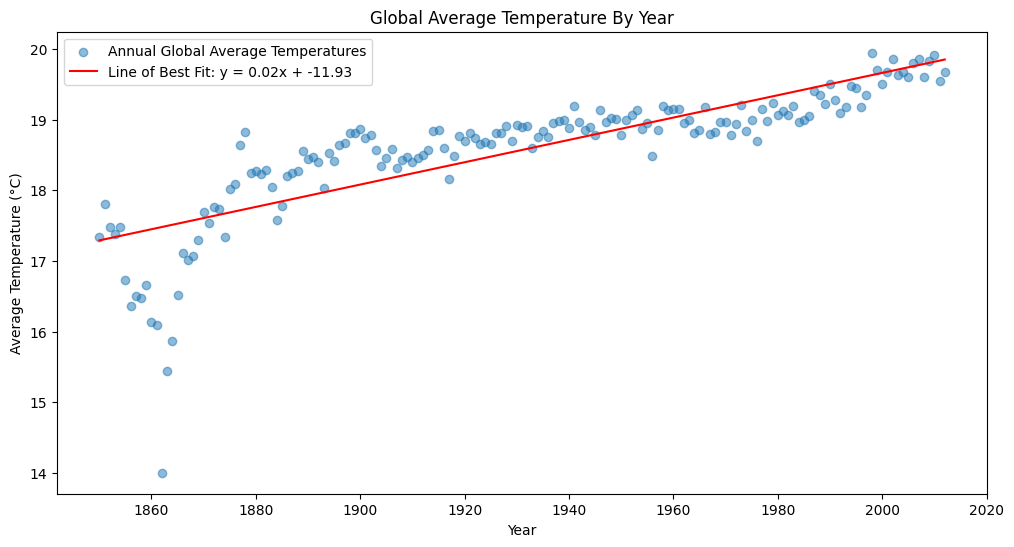

In [65]:
# Visualize global correlation (is the linear model a good fit?)
# Assuming df_no_missing is already defined and contains 'Year' and 'AverageTemperature'

df_no_missing_updated = df_no_missing_updated[df_no_missing_updated['Year'] >= 1850]

df_global_average = df_no_missing_updated.groupby('Year')['AverageTemperature'].mean().reset_index()
years = df_global_average['Year'].astype(float)
mean_temperatures = df_global_average['AverageTemperature'].astype(float)
m, b = np.polyfit(years, mean_temperatures, 1)
plt.figure(figsize=(12, 6))
plt.scatter(years, mean_temperatures, alpha=0.5, label='Annual Global Average Temperatures')
plt.plot(years, m*years + b, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')

global_correlation = years.corr(mean_temperatures)
print(f"Global Correlation between Year and Average Temperature: {global_correlation}")

plt.title('Global Average Temperature By Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

Global correlation between year and Average Temperature is pretty low, only 0.148. This means the simple variable of time explains about 14% of the variance in Average Temperature.

In [66]:
continent_counts = df_no_missing_updated['Continent'].value_counts()
print('Counts for each continent:\n', continent_counts)

kcc_counts = df_no_missing_updated['kcc'].value_counts()
print('\nCounts for each climate classification:\n', kcc_counts)

Counts for each continent:
 Continent
Asia             8602
Africa           2740
South America    1542
Europe           1304
North America    1141
Oceania           323
Name: count, dtype: int64

Counts for each climate classification:
 kcc
Aw       2279
BSh      1952
Cfa      1464
BWh      1375
Ocean    1366
BSk      1130
Cfb       948
Dfb       815
Csa       652
Cwa       625
Dwa       489
Am        485
Af        480
Dwb       326
As        322
Cwb       297
Dfa       163
BWk       163
Csb       163
ET        158
Name: count, dtype: int64


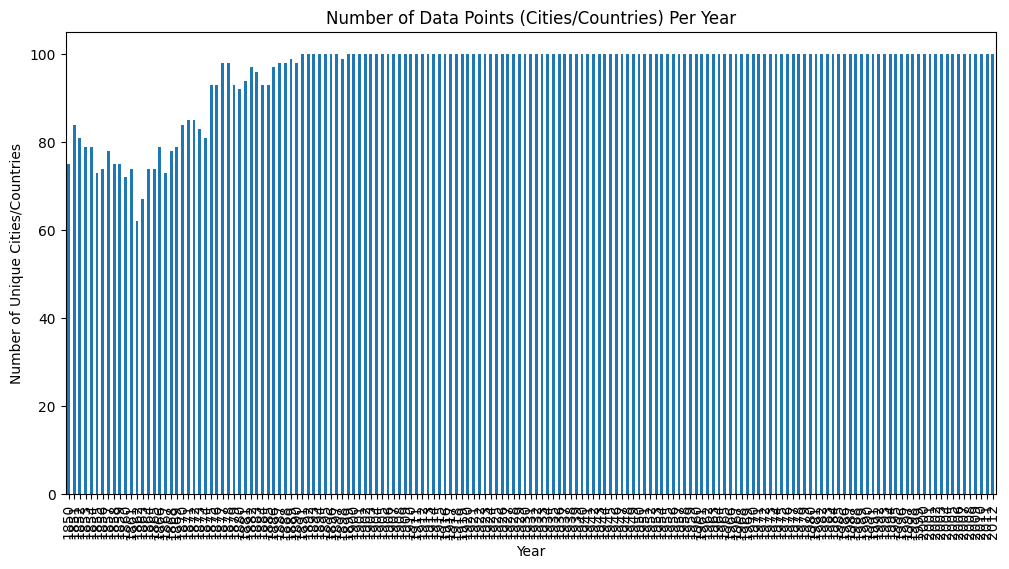

start_year is 1850


In [67]:
# Group by Year and count the number of unique cities/countries contributing to the data
data_points_by_year = df_no_missing_updated.groupby('Year')['City'].nunique()

# Plot the number of data points per year to visually assess the balance
plt.figure(figsize=(12, 6))
data_points_by_year.plot(kind='bar')
plt.title('Number of Data Points (Cities/Countries) Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique Cities/Countries')
plt.show()

# Get counts of how many years each city/country has data for
city_counts = df_no_missing_updated.groupby('City')['Year'].nunique()

# Filter cities/countries to those present in all years
consistent_cities = city_counts[city_counts >= 66].index.tolist()
df_consistent_cities = df_no_missing_updated[df_no_missing_updated['City'].isin(consistent_cities)]

# Recalculate the averages using the consistent set of cities/countries
df_continent_year_avg_temp_consistent = df_consistent_cities.groupby(['Continent', 'Year'])['AverageTemperature'].mean().reset_index()
df_kcc_year_avg_temp_consistent = df_consistent_cities.groupby(['kcc', 'Year'])['AverageTemperature'].mean().reset_index()

# Determine the start year for analysis based on data balance
start_year = 1850
print(f'start_year is {start_year}')

# Filter the consistent datasets to only include data from the start year onwards
df_continent_year_avg_temp_consistent = df_continent_year_avg_temp_consistent[df_continent_year_avg_temp_consistent['Year'] >= start_year]
df_kcc_year_avg_temp_consistent = df_kcc_year_avg_temp_consistent[df_kcc_year_avg_temp_consistent['Year'] >= start_year]


Correlation between Year and Average Temperature for Africa: 0.78670902966879


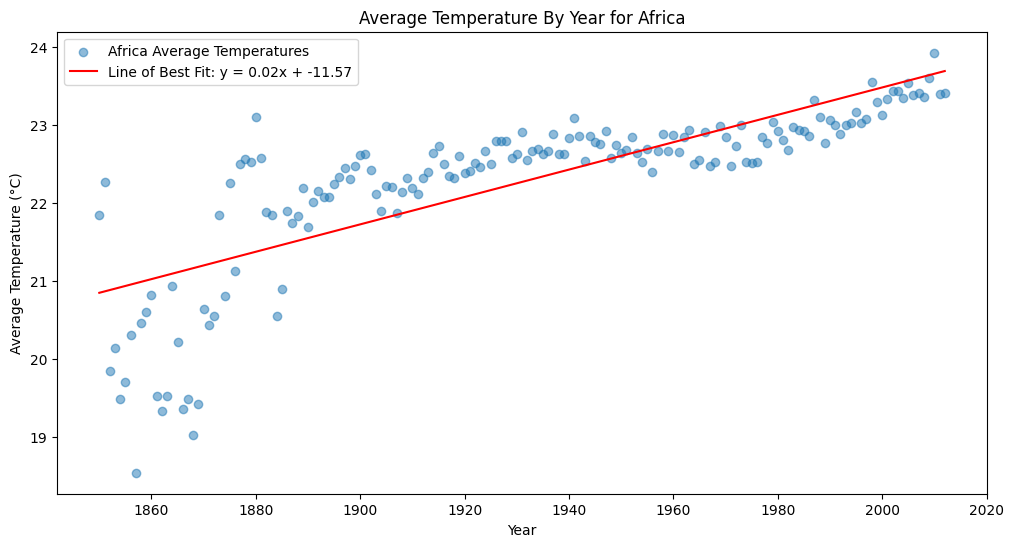

Correlation between Year and Average Temperature for Asia: 0.7128105356379362


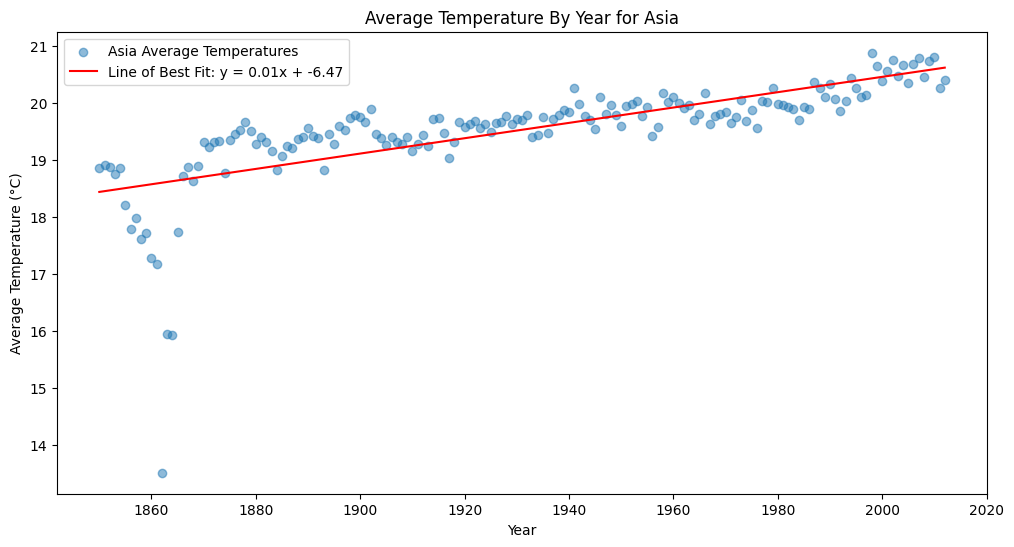

Correlation between Year and Average Temperature for Europe: 0.5900410434500735


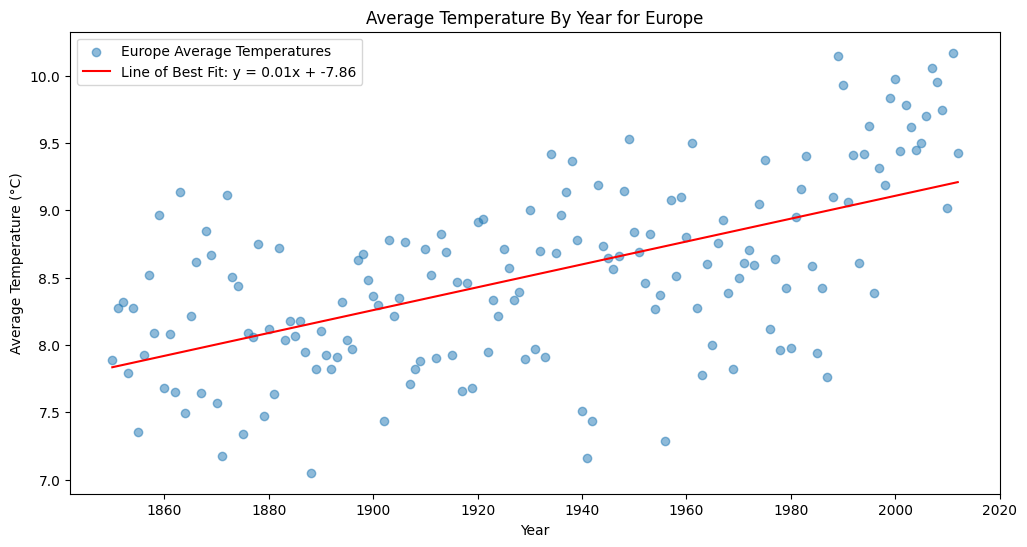

Correlation between Year and Average Temperature for North America: 0.7240211935806401


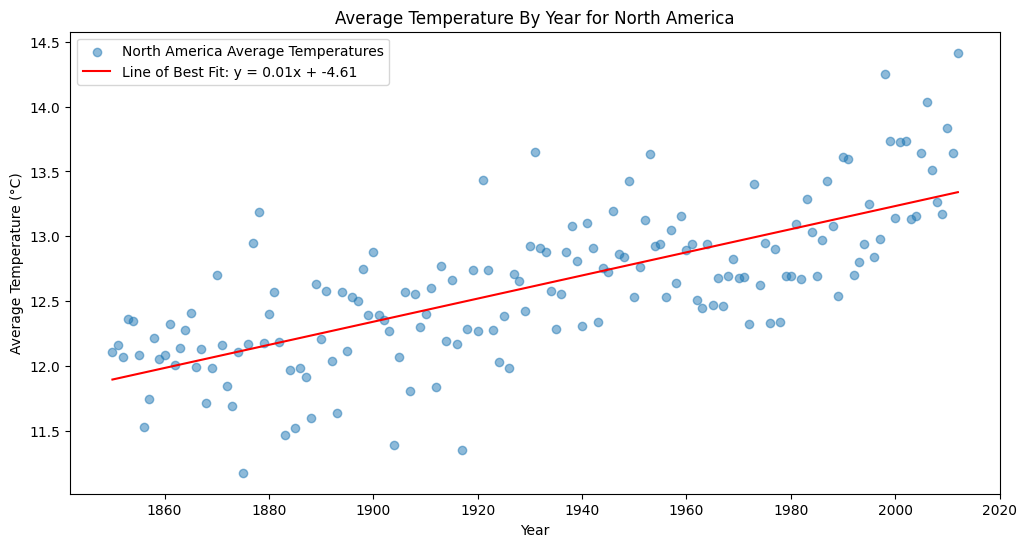

Correlation between Year and Average Temperature for Oceania: 0.5496207465545933


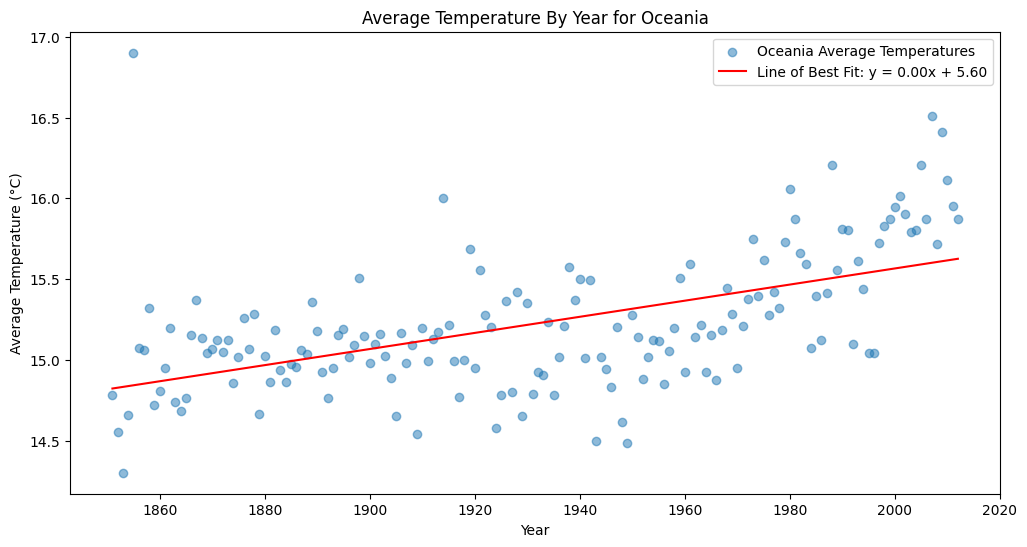

Correlation between Year and Average Temperature for South America: 0.5812048436527424


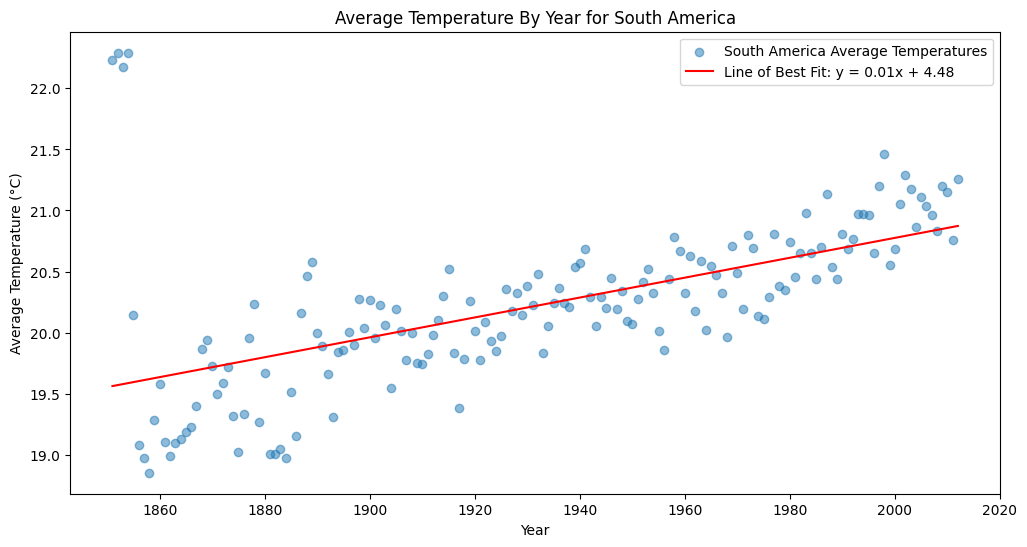

In [68]:
# Aggregate temperatures by continent and year, then calculate mean
#df_continent_year_avg_temp_consistent = df_no_missing_updated.groupby(['Continent', 'Year'])['AverageTemperature'].mean().reset_index()

# Calculate correlation and plot for each continent
for continent in df_continent_year_avg_temp_consistent['Continent'].unique():
    # Filter the DataFrame for the current continent
    df_continent = df_continent_year_avg_temp_consistent[df_continent_year_avg_temp_consistent['Continent'] == continent]
    
    # Perform the correlation calculation
    continent_correlation = df_continent['Year'].astype(float).corr(df_continent['AverageTemperature'].astype(float))
    print(f"Correlation between Year and Average Temperature for {continent}: {continent_correlation}")
    
    # Get the years and average temperatures for plotting
    years = df_continent['Year'].astype(float)
    avg_temps = df_continent['AverageTemperature'].astype(float)
    
    # Calculate the line of best fit
    m, b = np.polyfit(years, avg_temps, 1)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(years, avg_temps, alpha=0.5, label=f'{continent} Average Temperatures')
    plt.plot(years, m*years + b, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')
    plt.title(f'Average Temperature By Year for {continent}')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature (°C)')
    plt.legend()
    plt.show()

Correlation between Year and Average Temperature for Af: 0.7182977897301948


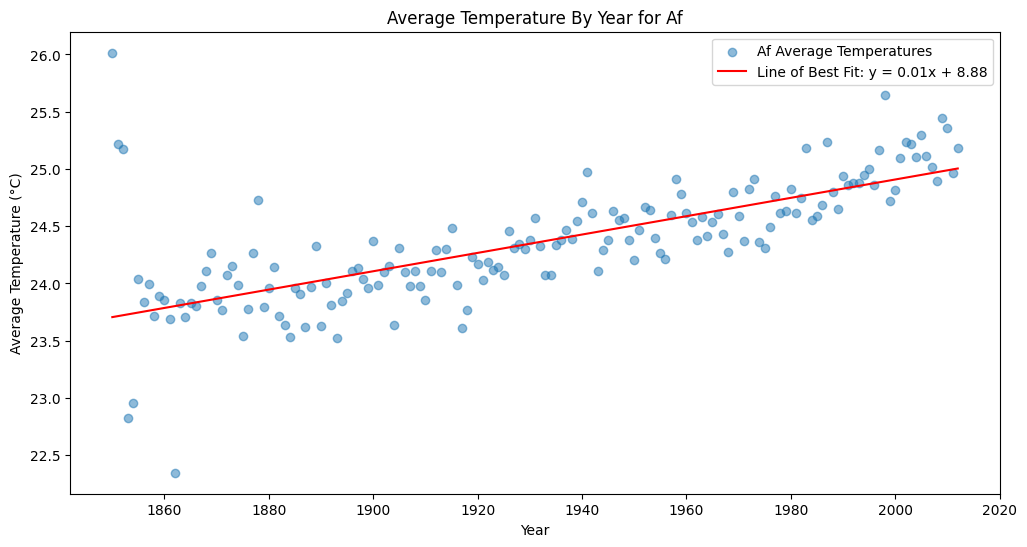

Correlation between Year and Average Temperature for Am: 0.8424342587436403


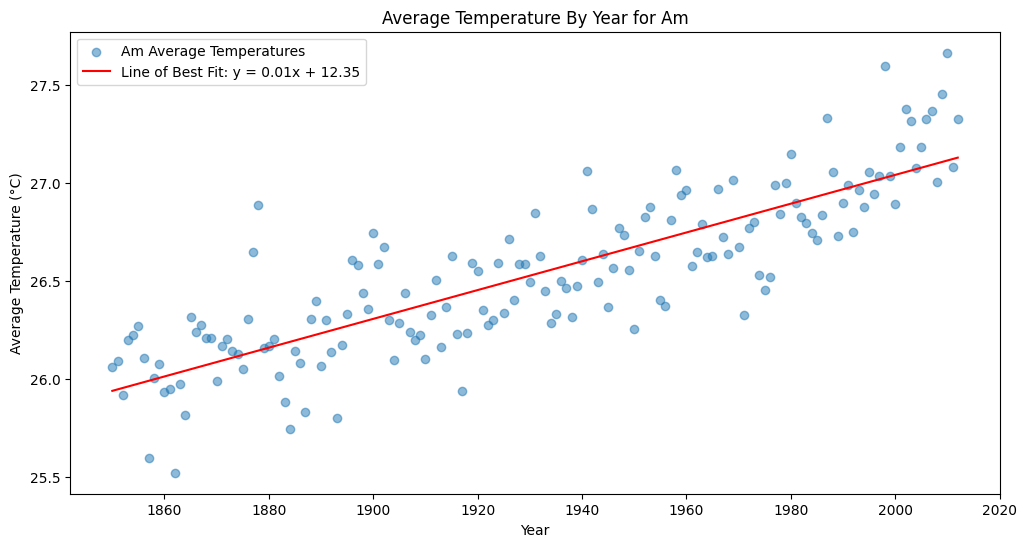

Correlation between Year and Average Temperature for As: 0.5808276827533833


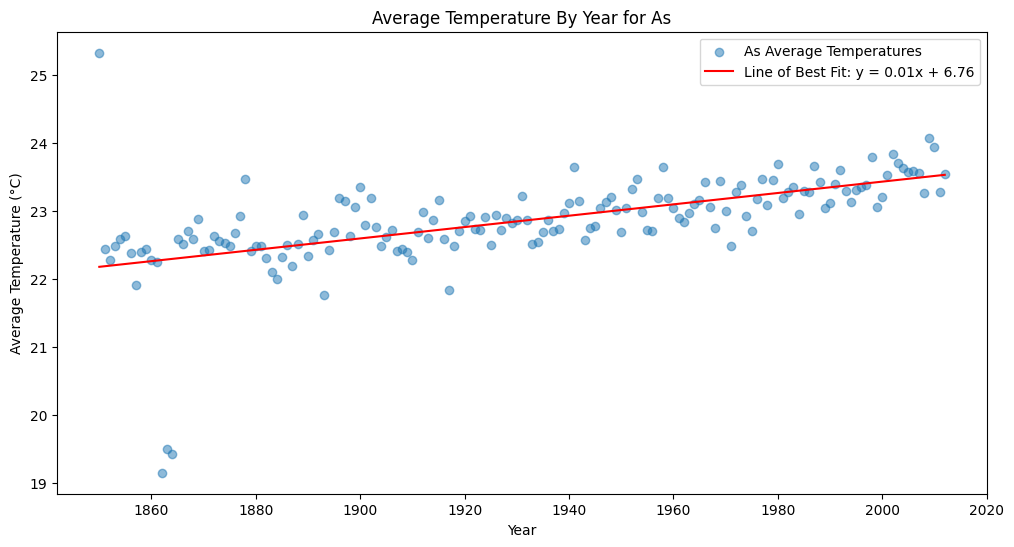

Correlation between Year and Average Temperature for Aw: 0.7900131164543672


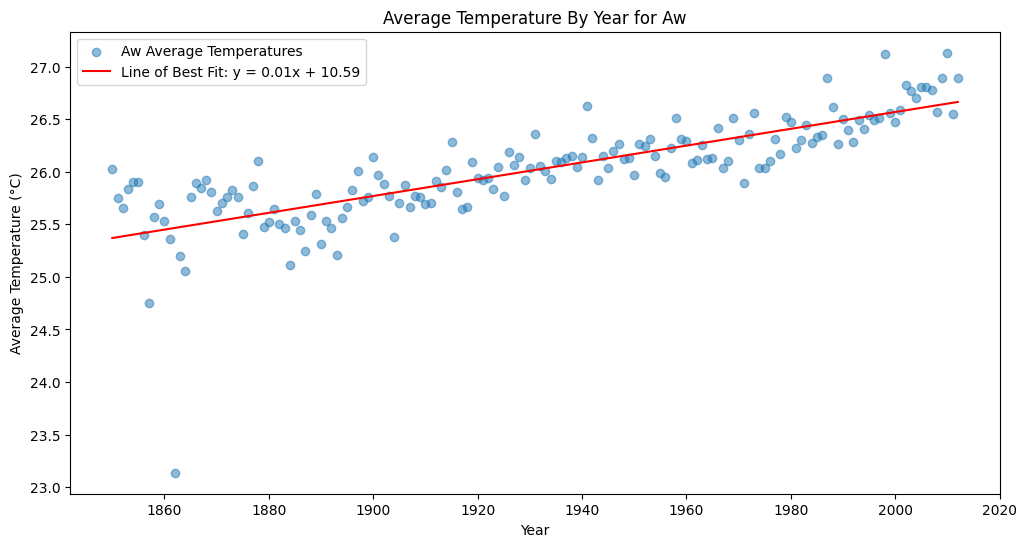

Correlation between Year and Average Temperature for BSh: 0.5653340745171238


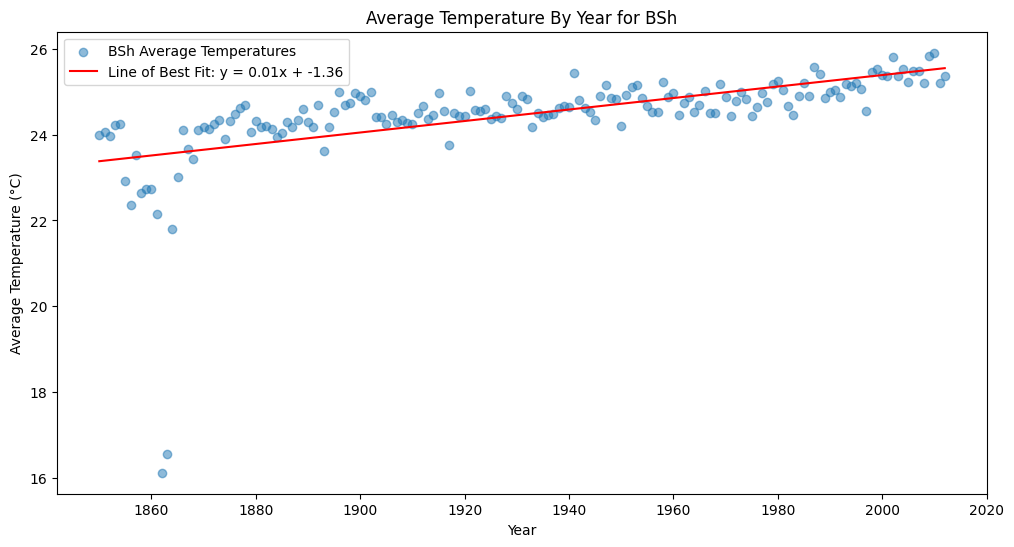

Correlation between Year and Average Temperature for BSk: 0.8195721903261868


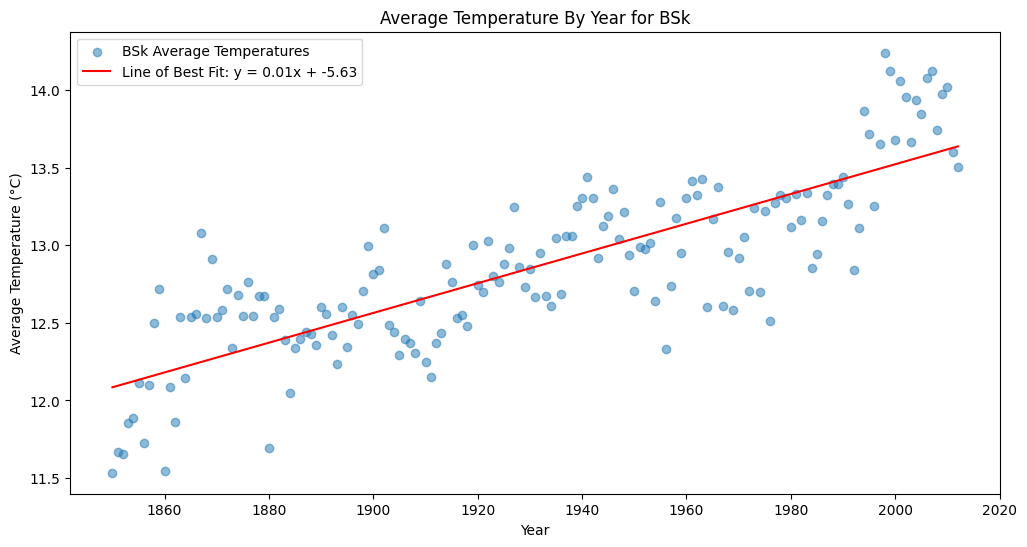

Correlation between Year and Average Temperature for BWh: 0.5871629246519703


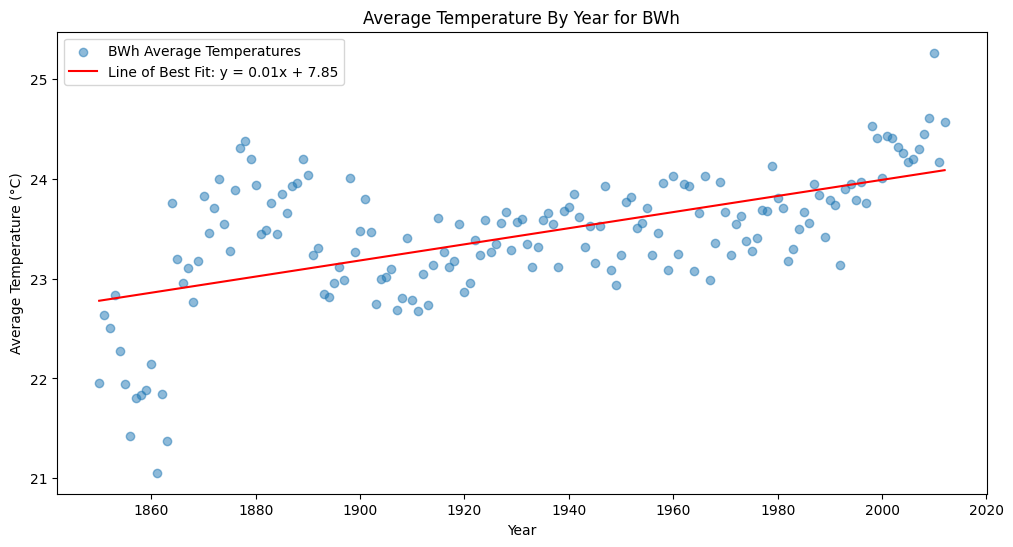

Correlation between Year and Average Temperature for BWk: 0.6417471812108846


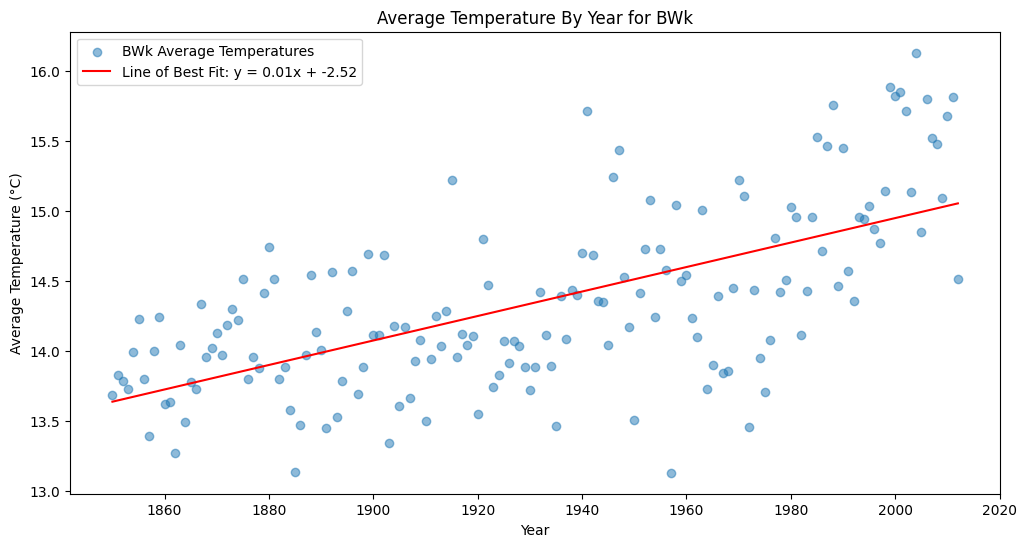

Correlation between Year and Average Temperature for Cfa: 0.7825972558229215


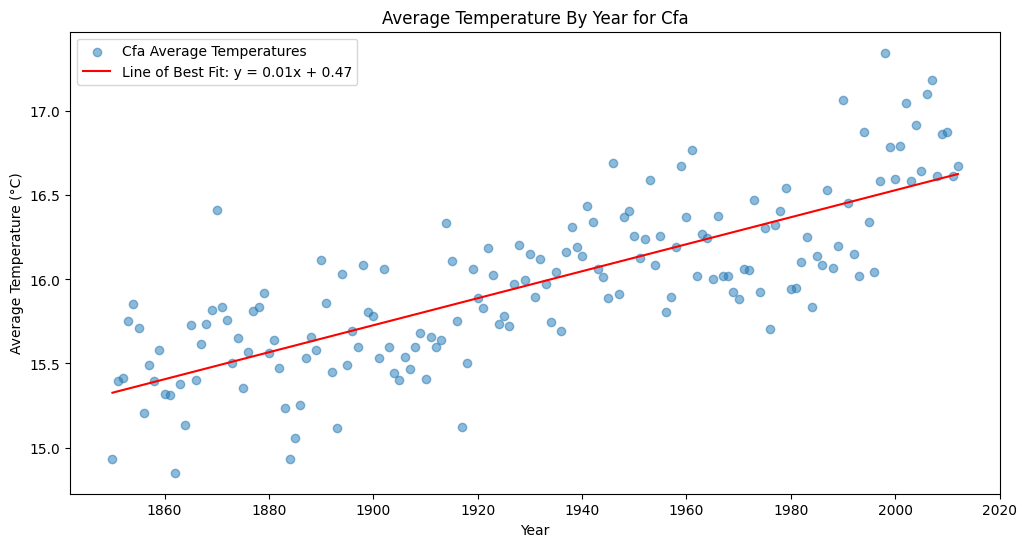

Correlation between Year and Average Temperature for Cfb: 0.7877620266409681


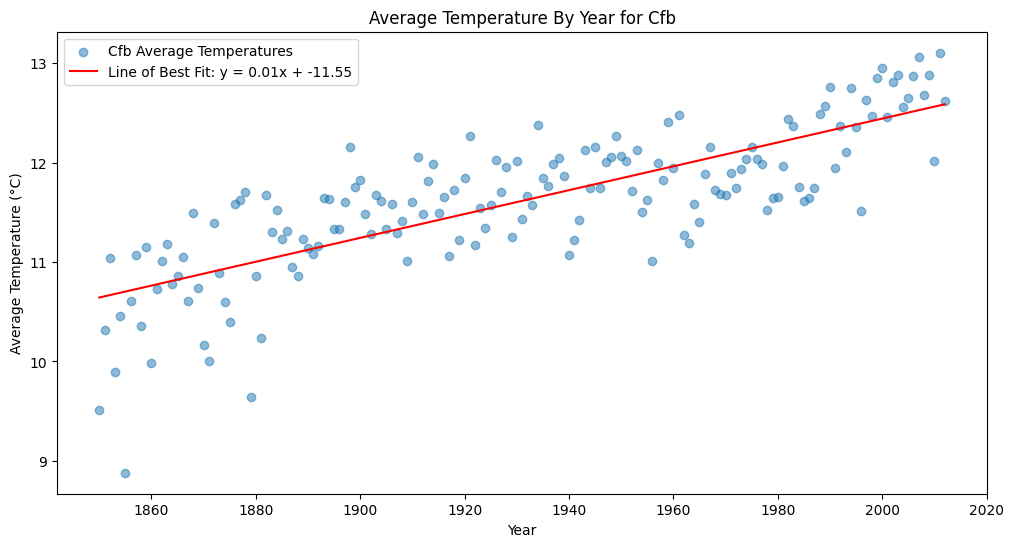

Correlation between Year and Average Temperature for Csa: 0.6595753279695136


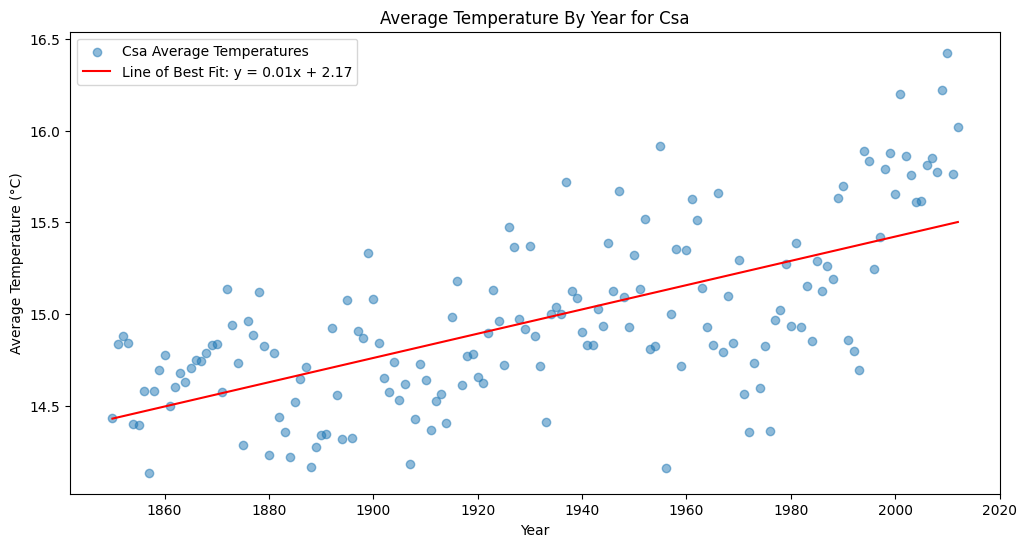

Correlation between Year and Average Temperature for Csb: 0.41278212559188865


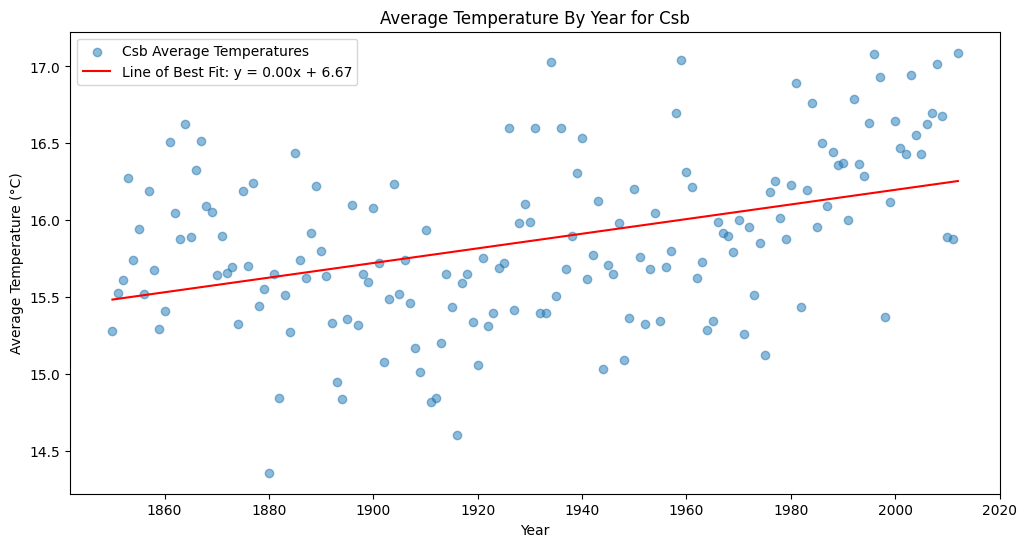

Correlation between Year and Average Temperature for Cwa: 0.8232242217095399


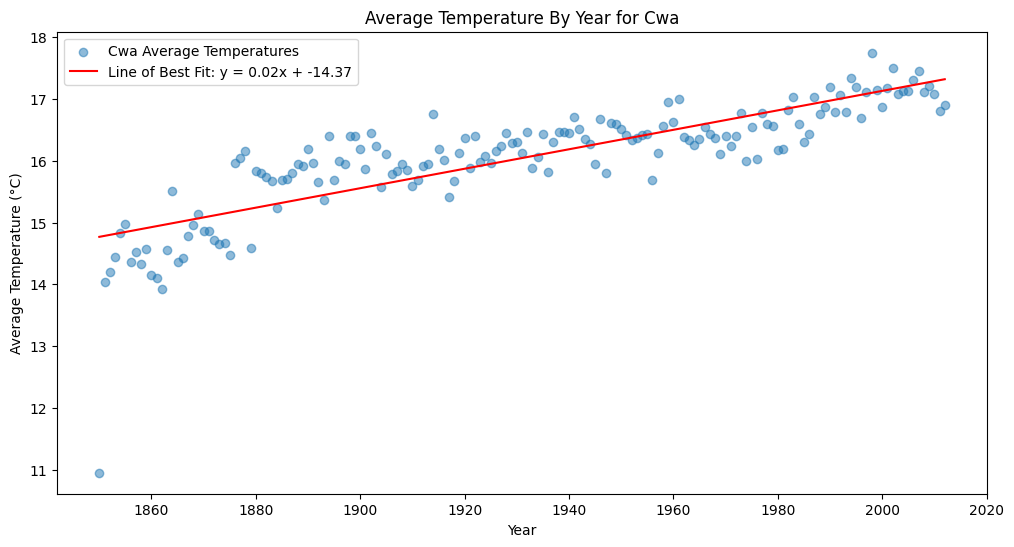

Correlation between Year and Average Temperature for Cwb: 0.7583760786108474


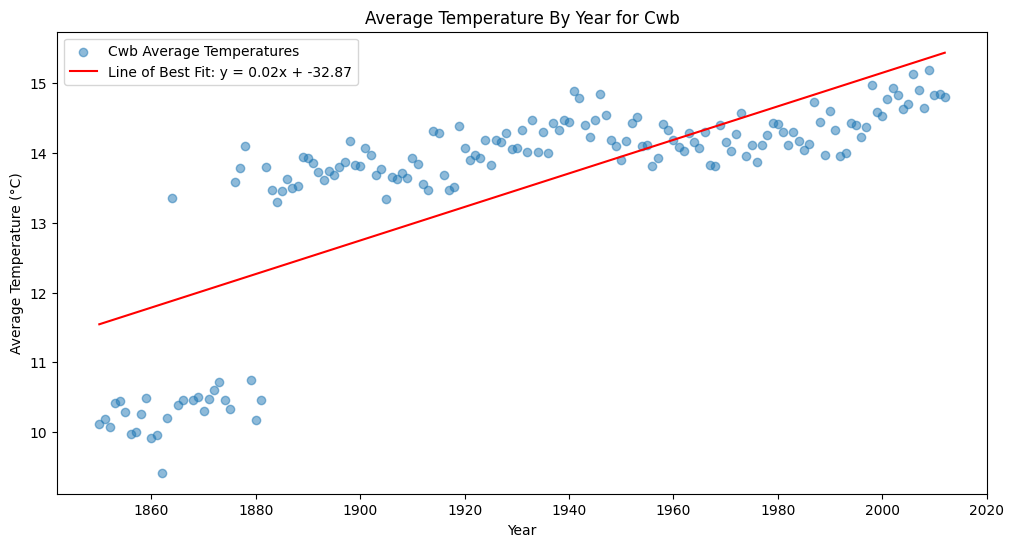

Correlation between Year and Average Temperature for Dfa: 0.5085043608611625


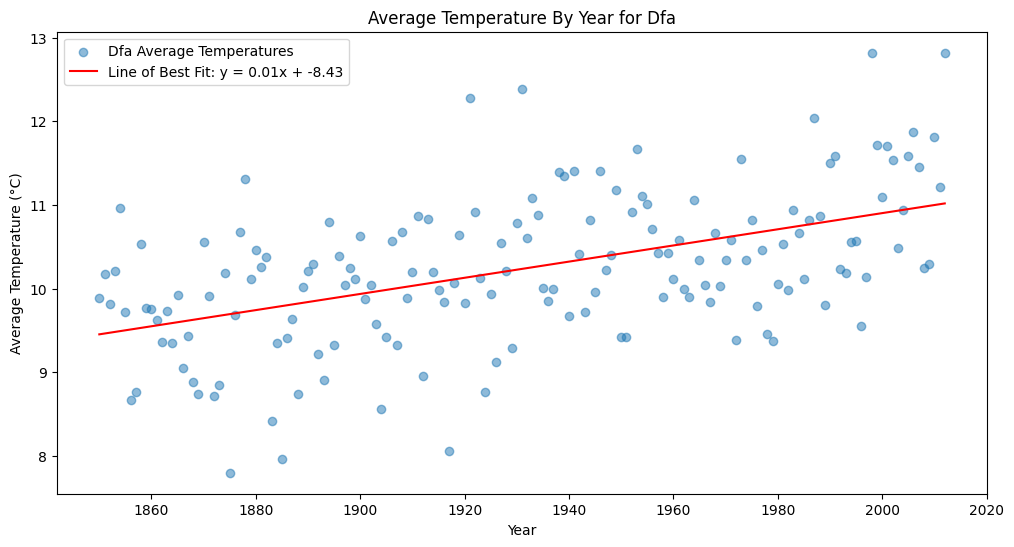

Correlation between Year and Average Temperature for Dfb: 0.607288031347458


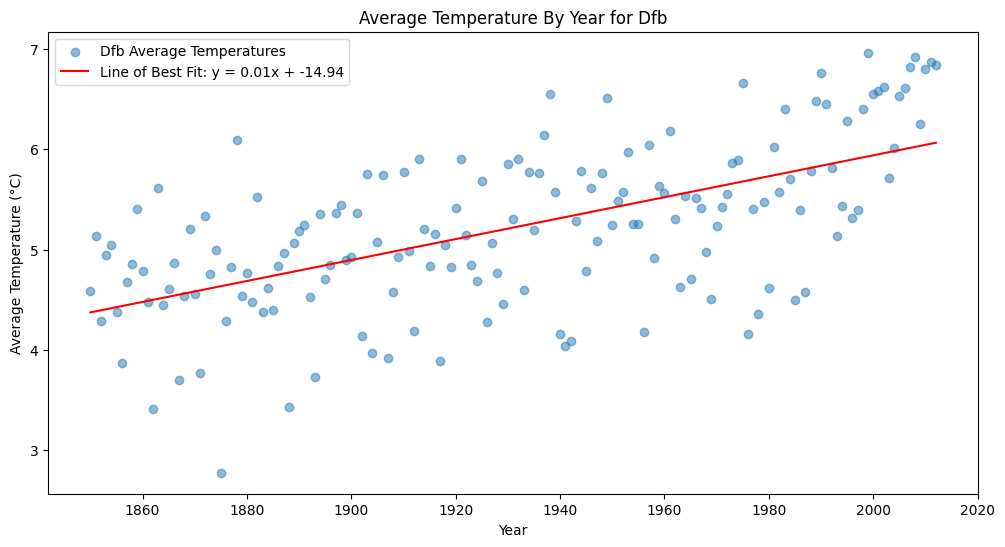

Correlation between Year and Average Temperature for Dwa: 0.68480565662837


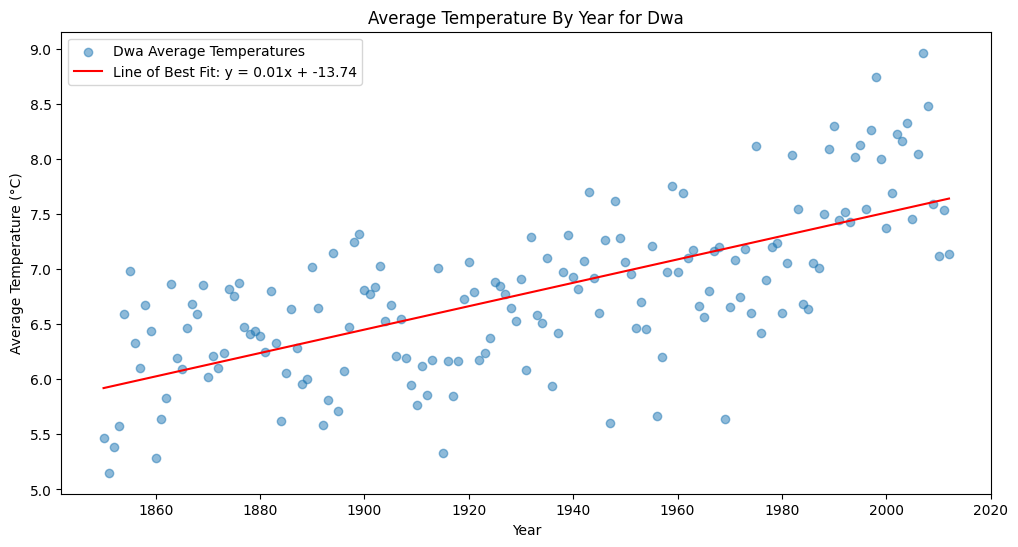

Correlation between Year and Average Temperature for Dwb: 0.7113784880919432


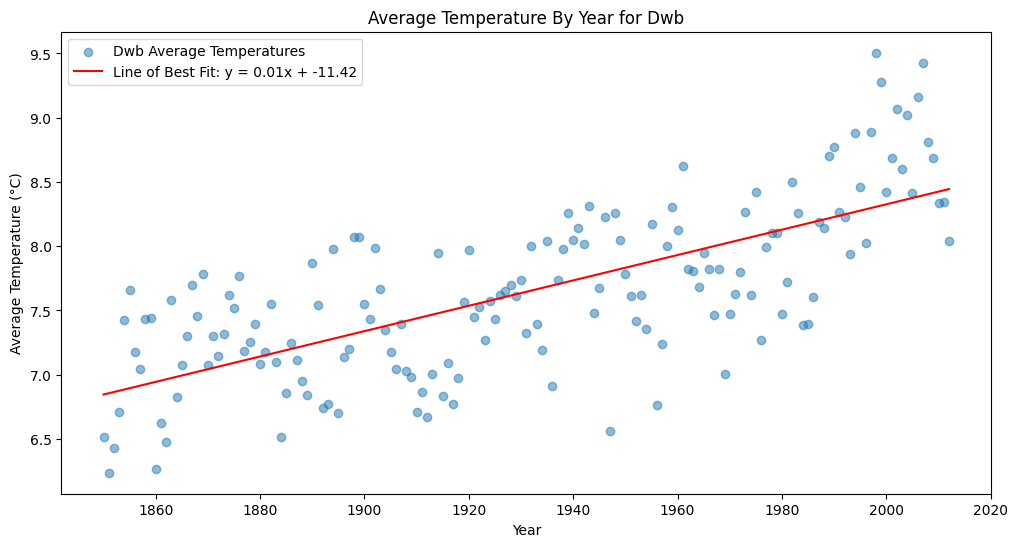

Correlation between Year and Average Temperature for ET: 0.7134748532995414


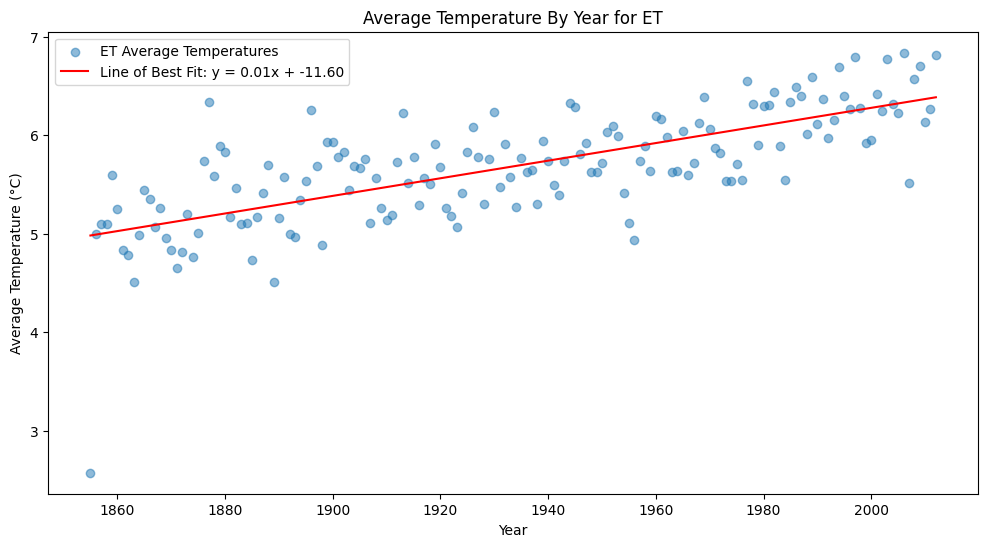

Correlation between Year and Average Temperature for Ocean: 0.8384937650388772


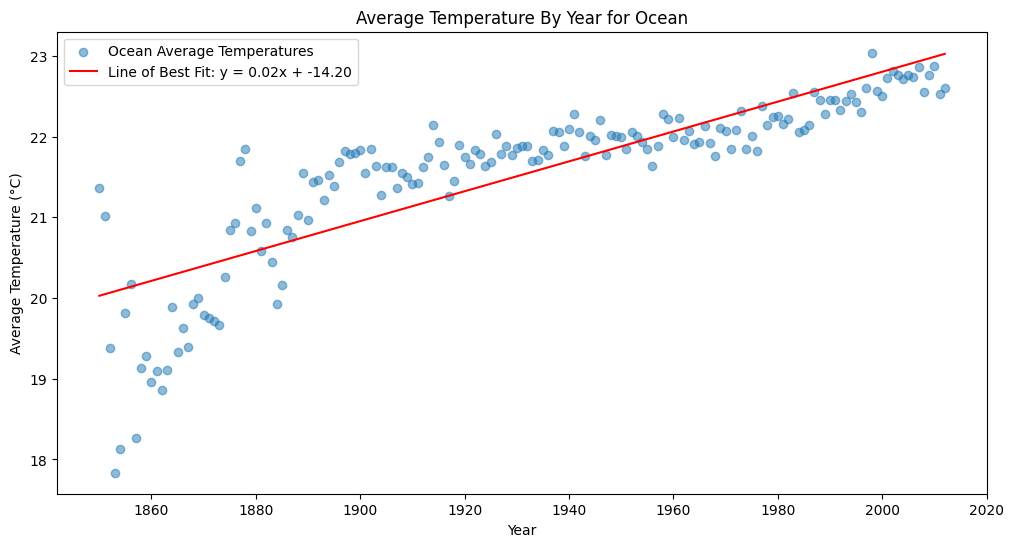

In [69]:
# Aggregate temperatures by continent and year, then calculate mean
#df_kcc_year_avg_temp = df_no_missing_updated.groupby(['kcc', 'Year'])['AverageTemperature'].mean().reset_index()

# Calculate correlation and plot for each continent
for climate in df_kcc_year_avg_temp_consistent['kcc'].unique():
    # Filter the DataFrame for the current continent
    df_kcc = df_kcc_year_avg_temp_consistent[df_kcc_year_avg_temp_consistent['kcc'] == climate]
    
    # Perform the correlation calculation
    kcc_correlation = df_kcc['Year'].astype(float).corr(df_kcc['AverageTemperature'].astype(float))
    print(f"Correlation between Year and Average Temperature for {climate}: {kcc_correlation}")
    
    # Get the years and average temperatures for plotting
    years = df_kcc['Year'].astype(float)
    avg_temps = df_kcc['AverageTemperature'].astype(float)
    
    # Calculate the line of best fit
    m, b = np.polyfit(years, avg_temps, 1)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(years, avg_temps, alpha=0.5, label=f'{climate} Average Temperatures')
    plt.plot(years, m*years + b, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')
    plt.title(f'Average Temperature By Year for {climate}')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature (°C)')
    plt.legend()
    plt.show()

In [22]:
continent_correlations = df_no_missing_updated.groupby('Continent').apply(
    lambda group: group['Year'].astype(float).corr(group['AverageTemperature'].astype(float)),
    include_groups=False
)
print('Correlation values for each continent:\n', continent_correlations)

kcc_correlations = df_no_missing_updated.groupby('kcc').apply(
    lambda group: group['Year'].astype(float).corr(group['AverageTemperature'].astype(float)),
    include_groups=False
)
print('\nCorrelation values for each unique climate classification:\n', kcc_correlations)

Correlation values for each continent:
 Continent
Africa           0.209839
Asia             0.034347
Europe           0.117967
North America    0.160912
Oceania          0.138861
South America    0.043299
dtype: float64

Correlation values for each unique climate classification:
 kcc
Af       0.166819
Am       0.549834
As      -0.059383
Aw       0.199826
BSh      0.151811
BSk      0.299668
BWh      0.156131
BWk      0.650413
Cfa      0.176931
Cfb      0.315195
Csa      0.116271
Csb      0.411992
Cwa      0.161563
Cwb      0.314717
Dfa      0.446108
Dfb      0.296531
Dwa      0.146526
Dwb      0.527319
ET       0.713475
Ocean    0.178432
dtype: float64


Climate types where the correlation between Year and Average Temperature is larger than the global correlation suggests that these regions are warming more rapidly than the planet as a whole, based on this dataset. Which regions are these, and what cities are in them?

It should be noted that Climate classifications aren't the end-all, be-all, i.e. there is variability within one climate type and geographic factors as well as human factors can influence temperature, including ocean currents, the urban heat island effect, deforestation, and pollution.

In [18]:
# Filter kcc_correlations to only include those larger than global_correlation
higher_than_global = kcc_correlations[kcc_correlations > global_correlation]

print("KCC correlations higher than the global correlation:")
print(higher_than_global)

KCC correlations higher than the global correlation:
kcc
Af       0.166819
Am       0.540676
Aw       0.197298
BSk      0.300897
BWh      0.154652
BWk      0.650413
Cfa      0.178939
Cfb      0.317797
Csb      0.411992
Cwa      0.161563
Cwb      0.314717
Dfa      0.439479
Dfb      0.295619
Dwb      0.527319
ET       0.713475
Ocean    0.178432
dtype: float64


In [1]:
# Visualize everything - is linear the correct approach?

# avg temp by continent by year
# how many representatives do we have from each continent

NameError: name 'kcc_correlations' is not defined

## Further Pattern Examination

-- look at magnitude of change
-- look at variance within each climate class
-- other measures or data exploration techniques we should employ?

In [ ]:
# Look at latitude/longitude distribution to determine binning

# Multidimensional approach - relationship between lat+long, kcc, and temp
# visualize it

In [ ]:
# summary/limitations